In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.mix import plot_comparison
from csng.utils.data import crop
from csng.data import get_dataloaders
from csng.utils.mix import seed_all, update_config_paths
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [2]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": dict(),
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


# Data

In [3]:
### prep data config
# brainreader mouse data
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 8,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (36, 64),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}

In [4]:
dls, neuron_coords = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        for data_key, dset in zip(dl.data_keys, dl.datasets):
            config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  brainreader_mouse: 563 batches
    data keys: 6
    size of datasets: 4504
val:
  brainreader_mouse: 63 batches
    data keys: 6
    size of datasets: 504
test:
  brainreader_mouse: 5 batches
    data keys: 6
    size of datasets: 40


Training dataset:	 4504 samples
Validation dataset:	 504 samples
Test dataset:		 40 samples

stimuli:
  torch.Size([8, 1, 36, 64])
  min=-2.333  max=2.894
  mean=0.426  std=1.125
responses:
  torch.Size([8, 8587])
  min=0.000  max=11.465
  mean=0.381  std=0.453


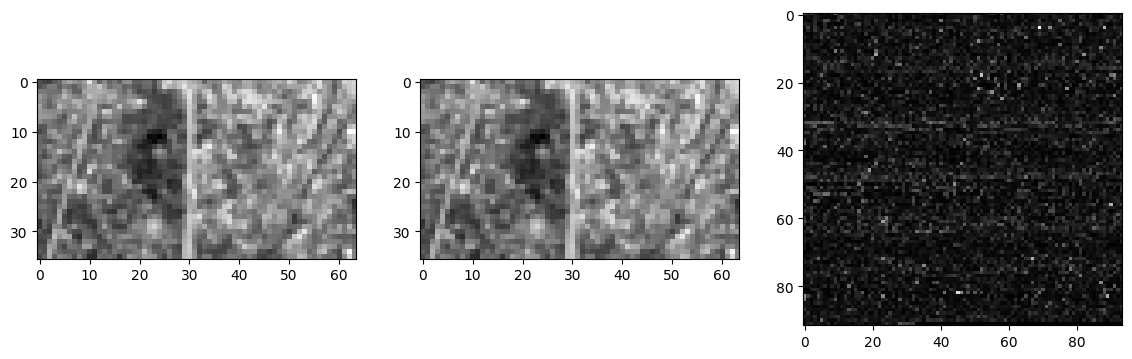

In [5]:
### show data
sample_dataset = "brainreader_mouse"
sample_data_key = "6"
tier = "test"
sample_idx = 0

datapoint = next(iter(dls[tier][sample_dataset].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][sample_dataset].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][sample_dataset].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][sample_dataset].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")

---
# Models

### Inverted Encoder

In [95]:
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.models.ensemble import EnsembleInvEnc

inv_enc = EnsembleInvEnc(
    encoder_paths=[
        os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    ],
    encoder_config={
        "img_dims": (1, 36, 64),
        "stim_pred_init": "randn",
        "lr": 2000,
        "n_steps": 1000,
        "img_grad_gauss_blur_sigma": 1,
        "jitter": None,
        "mse_reduction": "per_sample_mean_sum",
        "device": config["device"],
    },
    use_brainreader_encoder=True,
    get_encoder_fn=get_encoder_brainreader,
    device=config["device"],
)

[INFO] Loading encoder checkpoint from /media/jan/ext_ssd/csng_data/models/encoder_ball.pt


/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


## GAN

In [6]:
### config for model to load
config["decoder"] = {
    "load_ckpt": {
        "load_only_core": False,
        "load_best": False,
        "load_opter_state": True,
        "load_history": True,
        "reset_best": False,
        "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2024-12-10_02-52-29", "decoder_186.pt"),
        "resume_checkpointing": False,
        "resume_wandb_id": None,
    },
}

def merge_configs_fn(cfg, ckpt_cfg):
    load_ckpt_cfg = deepcopy(cfg["decoder"]["load_ckpt"])
    cfg = ckpt_cfg = update_config_paths(config=ckpt_cfg, new_data_path=DATA_PATH)
    cfg["decoder"]["load_ckpt"] = load_ckpt_cfg
    return cfg, ckpt_cfg

In [9]:
### load model
cfg, gan, loss_fn, history, best, ckpt = init_gan_decoder(config=config, merge_configs_fn=merge_configs_fn)
_ = gan.eval()

[INFO] Loading checkpoint from /media/jan/ext_ssd/csng_data/models/gan/2024-12-10_02-52-29/decoder_186.pt...


In [22]:
### collect predictions
from collections import defaultdict

denom_data_keys = {}
preds, targets, resps = defaultdict(list), defaultdict(list), defaultdict(list)

### run eval
dls, _ = get_dataloaders(config)
for k, dl in dls["test"].items(): # different data sources (cat_v1, mouse_v1, ...)
    for b in dl:
        ### combine losses from all data keys
        for dp in b:
            ### get predictions
            stim_pred = gan(
                dp["resp"],
                data_key=dp["data_key"],
                neuron_coords=dp["neuron_coords"],
                pupil_center=dp["pupil_center"],
            )

            ### calc metrics
            # for loss_fn_name, loss_fn in loss_fns[dp["data_key"]].items():
            #     losses[dp["data_key"]][loss_fn_name] += loss_fn(stim_pred, dp["stim"], data_key=dp["data_key"], phase="val").item()

            ### append for later batched metric calculation
            preds[dp["data_key"]].append(stim_pred.detach().cpu())
            targets[dp["data_key"]].append(dp["stim"].cpu())
            resps[dp["data_key"]].append(dp["resp"].cpu())

            denom_data_keys[dp["data_key"]] = denom_data_keys[dp["data_key"]] + dp["stim"].shape[0] if dp["data_key"] in denom_data_keys else dp["stim"].shape[0]

In [23]:
preds = {k: torch.cat(v, dim=0) for k, v in preds.items()}
targets = {k: torch.cat(v, dim=0) for k, v in targets.items()}
resps = {k: torch.cat(v, dim=0) for k, v in resps.items()}

preds, targets, resps

({'6': tensor[40, 1, 36, 64] n=92160 x∈[-6.384, 7.347] μ=-1.425 σ=2.768},
 {'6': tensor[40, 1, 36, 64] n=92160 x∈[-2.333, 2.915] μ=-0.318 σ=1.528},
 {'6': tensor[40, 8587] n=343480 x∈[2.803e-10, 18.368] μ=0.415 σ=0.526})

In [104]:
def batchwise_pearson_correlation(Z, B):
    assert Z.ndim == 2 and B.ndim == 2, "Input tensors must be 2D"
    assert Z.shape[0] == B.shape[0], "Input tensors must have the same batch size"

    # Calculate means
    Z_mean = torch.mean(Z, dim=1, keepdim=True)
    B_mean = torch.mean(B, dim=1, keepdim=True)

    # Subtract means
    Z_centered = Z - Z_mean
    B_centered = B - B_mean

    # Calculate Pearson correlation coefficient
    numerator = Z_centered @ B_centered.T
    Z_centered_norm = torch.linalg.norm(Z_centered, dim=1, keepdim=True)
    B_centered_norm = torch.linalg.norm(B_centered, dim=1, keepdim=True)
    denominator = Z_centered_norm @ B_centered_norm.T

    pearson_correlation = (numerator / denominator)

    return pearson_correlation
   

def pixcorr(stim_pred, stim):
    assert len(stim_pred) == len(stim), "Number of predicted images must match number of original images"

    stim_flat = stim.view(len(stim), -1)
    stim_pred_flat = stim_pred.view(len(stim_pred), -1)

    corr_mean = torch.mean(torch.diag(batchwise_pearson_correlation(stim_flat, stim_pred_flat)))

    return corr_mean

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision import transforms

class TwoWayAlexNet(torch.nn.Module):
    """
    Modified from https://github.com/MedARC-AI/MindEyeV2

    Citation:
      Scotti, Tripathy, Torrico, Kneeland, Chen, Narang, Santhirasegaran, Xu, Naselaris, Norman, & Abraham.
      MindEye2: Shared-Subject Models Enable fMRI-To-Image With 1 Hour of Data. International Conference on
      Machine Learning. (2024). arXiv:2403.11207
    """
    def __init__(
        self,
        inp_zscored: bool = False,
        feature_layers=["features.4", "features.11"],
        avg_across_layers: bool = False,
        device: str = "cuda",
    ):
        super().__init__()

        self.device = device
        self.inp_zscored = inp_zscored
        self.feature_layers = feature_layers
        self.avg_across_layers = avg_across_layers

        ### feature extractor
        self.alex_model = create_feature_extractor(
            alexnet(weights=AlexNet_Weights.IMAGENET1K_V1),
            return_nodes=self.feature_layers,
        ).to(self.device)
        self.alex_model.eval().requires_grad_(False)

        ### preprocessing transforms
        self.preprocess = transforms.Compose([
            transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1) if x.shape[1] == 1 else x),
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        ])
        if not self.inp_zscored:
            self.preprocess.transforms.append(
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            )

    @torch.no_grad()
    def two_way_identification(self, all_recons, all_images, feature_layer=None, return_avg=True):
        ### prepare data
        preds = self.alex_model(self.preprocess(all_recons).to(self.device))
        reals = self.alex_model(self.preprocess(all_images).to(self.device))
        if feature_layer is None:
            preds = preds.float().flatten(1).cpu().numpy()
            reals = reals.float().flatten(1).cpu().numpy()
        else:
            preds = preds[feature_layer].float().flatten(1).cpu().numpy()
            reals = reals[feature_layer].float().flatten(1).cpu().numpy()

        ### calculate correlations and success rates
        r = np.corrcoef(reals, preds)
        r = r[:len(all_images), len(all_images):]
        congruents = np.diag(r)

        success = r < congruents
        success_cnt = np.sum(success, 0)

        if return_avg:
            perf = np.mean(success_cnt) / (len(all_images) - 1)
            return perf
        else:
            return success_cnt, (len(all_images) - 1)

    def forward(self, preds, targets):
        results = dict()
        for feature_layer in self.feature_layers:
            results[feature_layer] = self.two_way_identification(
                all_recons=preds,
                all_images=targets,
                feature_layer=feature_layer,
            ).mean()

        if self.avg_across_layers:
            return sum(results.values()) / len(results)

        return results

In [128]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import alexnet, AlexNet_Weights
from torchvision import transforms
alex_weights = AlexNet_Weights.IMAGENET1K_V1

device = 'cuda' if torch.cuda.is_available() else 'cpu'
alex_model = create_feature_extractor(alexnet(weights=AlexNet_Weights.IMAGENET1K_V1), return_nodes=['features.4','features.11']).to(device)
alex_model.eval().requires_grad_(False)

AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
)

In [133]:
two_way_alex = TwoWayAlexNet(
    inp_zscored=True,
    feature_layers=["features.4", "features.11"],
    device=device,
)
two_way_alex(preds[sample_data_key], targets[sample_data_key])

{'features.4': 0.9833333333333334, 'features.11': 0.8237179487179487}

In [110]:
# see alex_weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(
    preds[sample_data_key].repeat(1, 3, 1, 1).to(device).float(),
    targets[sample_data_key].repeat(1, 3, 1, 1),
    alex_model,
    preprocess,
    'features.4',
)
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.9833


In [150]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
# from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

def minmax_normalize(x, dim=(1,2,3), eps=1e-8, min=None, max=None, inplace=False):
    ### to [0,1] range
    x_min = x.amin(dim=dim, keepdim=True) if min is None else min
    x_max = x.amax(dim=dim, keepdim=True) if max is None else max

    if inplace:
        x -= x_min
        x /= (x_max - x_min + eps)
        return x
    else:
        return (x - x_min) / (x_max - x_min + eps)


preprocess = transforms.Compose([
    # transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
    ### min-max normalize
    transforms.Lambda(lambda x: minmax_normalize(x, dim=(1,2,3), inplace=True)),
])

# convert image to grayscale with rgb2grey
# img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
# recon_gray = rgb2gray(preprocess(all_recons).permute((0,2,3,1)).cpu())
# print("converted, now calculating ssim...")

# targets = preprocess(targets[sample_data_key]).permute((0,2,3,1)).cpu()
# preds = preprocess(preds[sample_data_key]).permute((0,2,3,1)).cpu()

ssim_score = []
for im, rec in tqdm(zip(targets.numpy().astype(np.float32), preds.numpy().astype(np.float32)), total=len(targets)):
    ssim_score.append(ssim(
        rec.squeeze(-1),
        im.squeeze(-1),
        # multichannel=False,
        gaussian_weights=True,
        sigma=1.5,
        use_sample_covariance=False,
        data_range=1.0
    ))

ssim = np.mean(ssim_score)
print(ssim)

100%|██████████| 40/40 [00:00<00:00, 2971.42it/s]

0.26593138098635505


In [155]:
from csng.losses import Loss, SSIM

my_ssim = Loss(config=dict(
    loss_fn=SSIM(),
    window=None,
    standardize=True,
))
my_ssim(preds.permute(0,3,1,2), targets.permute(0,3,1,2))

tensor[40] x∈[0.116, 0.503] μ=0.266 σ=0.091

## Brain similarity metric

In [60]:
import torch.nn.functional as F
from torch import Tensor
from typing import Tuple
from csng.utils.data import standardize, normalize, crop

class EncodedBrainSimilarity(torch.nn.Module):
    def __init__(
        self,
        encoder,
        use_gt_resp: bool = True,
        resp_loss_fn = F.mse_loss,
        zscore_inp: bool = False,
        minmax_normalize_inp: bool = False,
        window=None, # (x1, x2, y1, y2)
        device="cuda",
    ):
        super().__init__()
        self.window = window
        self.use_gt_resp = use_gt_resp
        self.zscore_inp = zscore_inp
        self.minmax_normalize_inp = minmax_normalize_inp
        self.resp_loss_fn = resp_loss_fn
        self.device = device
        self.encoder = encoder
        self.encoder.to(self.device)
        self.encoder.requires_grad_(False)

    def _compute_brain_similarity(self, stim_pred: Tensor, stim: Tensor, resp: Tensor, **kwargs) -> Tensor:
        resp = resp.to(self.device) if self.use_gt_resp else self.encoder(stim_pred.to(self.device), **kwargs)
        stim_pred_resp = self.encoder(stim_pred.to(self.device), **kwargs)
        return self.resp_loss_fn(stim_pred_resp, resp)

    def forward(self, pred: Tensor, target: Tensor, resp: Tensor, **kwargs) -> Tensor:
        if self.window is not None:
            pred = crop(pred, win=self.window)
            target = crop(target, win=self.window)

        if self.zscore_inp:
            pred = normalize(pred)
            target = normalize(target)

        if self.minmax_normalize_inp:
            pred = standardize(pred)
            target = standardize(target)

        return self._compute_brain_similarity(stim_pred=pred, stim=target, resp=resp, **kwargs)

In [56]:
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader

encoder = get_encoder_brainreader(
    ckpt_path=os.path.join(DATA_PATH, "models", "encoder_b6.pt"),
    eval_mode=True,
    device=cfg["device"],
)

[INFO] Loading encoder checkpoint from /media/jan/ext_ssd/csng_data/models/encoder_b6.pt


/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [57]:
ck = torch.load(os.path.join(DATA_PATH, "models", "encoder_b6.pt"))

In [61]:
loss_fn = EncodedBrainSimilarity(
    encoder=encoder,
    use_gt_resp=True,
    resp_loss_fn=F.mse_loss,
    zscore_inp=False,
    minmax_normalize_inp=False,
    window=None,
)

loss_fn(
    pred=preds[sample_data_key],
    target=targets[sample_data_key],
    resp=resps[sample_data_key],
    data_key=sample_data_key,
)

tensor[] cuda:0 0.298